In [1]:
# Data cleaning
reactions = ["{ } < 'Alkene Addition Elimination, O, H' > { }","{ } < 'Alkene Addition Elimination, O, H' > { }"]
elminate = " {}<>''"
new_reaction = []
for reaction in reactions:
    word = ""
    for character in reaction:
        if character in elminate:
            pass
        else:
            word = word + character 
    new_reaction.append(word)
new_reaction 

['AlkeneAdditionElimination,O,H', 'AlkeneAdditionElimination,O,H']

# Things to add:
* order metbaolites according to order of first occurance (added)
* add name of reactions

**IMPORT DATA**

In [2]:
# Import Data Obtain from MOD
import pickle                    # Import pickle: Binary protocols for serializing and de-serializing a Python object structure.

# PRODUCTS
dbfile = open('products', 'rb')  # Open file in read binary mode    
products = pickle.load(dbfile)   # Import products
dbfile.close()                   # Close connection
# REACTANTS
dbfile = open('reactants', 'rb') # Open file in read binary mode       
reactants = pickle.load(dbfile)  # Import reactants
dbfile.close()                   # Close connection

**PREPARE DATA**

In [3]:
# Get together all molecules to do analysis 
# Reactant Network
network_r = []                           # Initialize a list to store reactants of a network
for reactant in reactants:               # Iterate over the reactants
    for molecule in reactants[reactant]: # Some reactions have more than 1 molecules, iterate over those
        network_r.append(molecule)       # append them to network_r

# Prouct Network
network_p = []                           # Initialize a list to store products of a network
for product in products:                 # Iterate over the products
    for molecule in products[product]:   # Some reactions have more than 1 molecules, iterate over those
        network_p.append(molecule)       # append them to network_p
        
network = network_r + network_p          # create a list containing the TOTAL NETWORK
#network                                 # Uncomment to visualize list 

In [4]:
network

['[O]',
 'O=[O+][O-]',
 '[OH.]',
 'O=[O+][O-]',
 '[H.]',
 'O=[O+][O-]',
 '[H.]',
 'O[O.]',
 '[OH.]',
 'O[O.]',
 'O[O.]',
 'O[O.]',
 '[OH.]',
 '[OH.]',
 '[OH.]',
 'O[O.]',
 '[OH.]',
 '[O]',
 '[O]',
 'O[O.]',
 '[Md]',
 '[O]',
 'O=O',
 '[Md]',
 '[O]',
 '[O]',
 '[Md]',
 '[OH.]',
 '[O]',
 '[Md]',
 '[H.]',
 'O=O',
 '[Md]',
 '[OH.]',
 '[H.]',
 '[Hf]',
 'O=O',
 '[Hf]',
 'O',
 '[Hf]',
 'O=[O+][O-]',
 '[H.]',
 'O[O.]',
 'O=O',
 'O=O',
 'O=O',
 'O[O.]',
 '[OH.]',
 'O=O',
 'O=O',
 '[H][H]',
 'O',
 'O=O',
 'O=O',
 'OO',
 'O',
 '[O]',
 '[O]',
 'OO',
 '[H.]',
 'O=O',
 '[OH.]',
 'O=O',
 '[Md]',
 'O=[O+][O-]',
 '[Md]',
 'O=O',
 '[Md]',
 'O[O.]',
 '[Md]',
 'O[O.]',
 '[Md]',
 'O',
 '[O]',
 '[O]',
 '[OH.]',
 '[H.]',
 '[O]',
 'O=O',
 'OO']

**DECLARE CANONICAL FUNCTION**

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Descriptors import ExactMolWt
enumerator = rdMolStandardize.TautomerEnumerator()
import os 
import numpy as np

def get_canonical(network):
    """ Gets the canonical SMILES strings and Molecule objects of tautomers  in a Network """
        # BASIC NOTATION
    # name  == SMILES string list
    # name_molecule == Molecule object list

    tautomer_molecules =[] # a list that will hold the most stable tautomer
    tautomer = []
    for i in range(0,len(network)):

        mol = Chem.MolFromSmiles(network[i])         # conver to mol object
        can = Chem.MolToSmiles(mol)                  # back to smiles (this will creat canonical strings)
        can_mol=Chem.MolFromSmiles(can)              # convert back to molto see if there are in fact canonical

        taut_mol = enumerator.Canonicalize(can_mol)  # get tautomer (it only works with molecule objects)
        tautomer_molecules.append(taut_mol)          # append to tuatomer_molecules list
        taut = Chem.MolToSmiles(mol)                 # convert to smiles
        tautomer.append(taut)                        # append to tuatomer (SMILES)list
    
    new_tautomer = []
    mol_tautomer = []
    for i in range(0,len(tautomer)):
        sm = Chem.MolToSmiles(tautomer_molecules[i]) #from the mol canoncial objects get the srtings that defined them
        mol_1 = Chem.MolFromSmiles(sm)               # convert back to mol object (this is done in order to get the canonical)
        # 2nd convert back to smiles
        can_1 = Chem.MolToSmiles(mol_1)              # convert them back to string out of mol (to take care of rotated molecules)
        new_tautomer.append(can_1)                   # append this to new_tatuomer
    

    return (new_tautomer)

**QUALITY CHECK**

In [6]:
try:
    new_network = get_canonical(network)
except:
    new_network = network    # if there is no canonical than do not get canonical
A = len(new_network) == len(network)
B = new_network == network
print("List has same size: ",A," List has same content: ",B)
if A == True and B == False:
    print("Test Pass")

List has same size:  True  List has same content:  True


**PROCESS THE DATA AFTER CANONICAL TRANSFORMATION**

In [7]:
new_reactants = new_network[0:len(network_r)] # Obtain a list of the new (canonical) reactants 
new_products  = new_network[len(network_r)::] # Obtain a list of the new (canonical) products 
reac = {}                                     # Create a dictionary to store {reaction_i: [reactant]}
prod = {}                                     # Create a dictionary to store {reaction_i: [product]}
a=0                                           # Variable for slicing 
b=0                                           # Variable for slicing 

# Dictionarize reactants 
for reactant in reactants:                          # Iiterate over reactants (before canonicalization) keys 
        if type(reactants[reactant]) == type("s"):  # If there is only on molecule the dictionary contains a string
            b = b + 1                               #  Add one to final Slicing value
        else:                                       # Else: If dict is not a string, than it is a list, in that case
            b = len(reactants[reactant]) + b        # Add the len of molecules to the final Slicing value

        #print(a,b)
        reac[reactant] = new_reactants[a:b]         # Slice the new_reactants list (canonical reactants) and store it in dic

        if type(reactants[reactant]) == type("s"):  # If there is only on molecule the dictionary contains a string
            a = a + 1                               #  Add one to final Slicing value
        else:
            a = len(reactants[reactant]) + a        # Else: If dict is not a string, than it is a list, in that case

### SAME CODE BUT FOR PRODUCTS ###

a=0                                                 # Reset Variable for slicing 
b=0                                                 # Reset Variable for slicing 
for product in products:
        if type(products[product]) == type("s"):
            b = b + 1
        else:
            b = len(products[product]) + b

        #print(a,b)
        prod[product] = new_products[a:b]

        if type(products[product]) == type("s"):
            a = a + 1
        else:
            a = len(products[product ]) + a


**QUALITY CHECK**

In [8]:
A = len(reac)== len(reactants)
B =  reac == reactants
print(" Reac List has same size: ",A," Reac List has same content: ",B)
A = len(prod)== len(products)
B =  prod == products
print(" Prod List has same size: ",A," Prod List has same content: ",B)
if A == True and B == False:
    print(" Test Pass")

 Reac List has same size:  True  Reac List has same content:  True
 Prod List has same size:  True  Prod List has same content:  True


**LETS UNDERSTAND OUR FILTERED DATA**

In [9]:
print("MOLECULES:",len(new_network),"UNIQUE MOLECULES:",len(set(new_network)))

MOLECULES: 80 UNIQUE MOLECULES: 11


In [10]:
# SET() does noy need any order (due to the fact that it was created for mathematical sets), lets do a trick to order nodes
# according to firs appearance (and delete duplicates)
mylist = list(dict.fromkeys(new_network))
len(mylist) 

11

**CREATE A DATA FRAME TO INTIALIZE S**

In [11]:
import pandas as pd
### BUILD THE STOCHIOMETRIC MATRIX ###
# The stochiometric matrix has  metabolites as rows and reactions as  columns

# INTIALIZE THE STOCHIOMETRIC MATRIX 
edges = list(reac.keys())       # Columns representing all the reactions
#nodes  = list(set(new_network)) # Rows representing  unique nodes
nodes = mylist                  # In this format Rows are ordered
S = pd.DataFrame(columns =edges, index=nodes ) # Genereate S
S

,reaction_0,reaction_1,reaction_2,reaction_3,reaction_4,reaction_5,reaction_6,reaction_7,reaction_8,reaction_9,reaction_10,reaction_11,reaction_12,reaction_13,reaction_14,reaction_15,reaction_16,reaction_17,reaction_18
[O],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O=[O+][O-],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[OH.],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[H.],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O[O.],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[Md],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O=O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[Hf],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[H][H],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
S = S.fillna(0) # Change Nan for 0's 
S

,reaction_0,reaction_1,reaction_2,reaction_3,reaction_4,reaction_5,reaction_6,reaction_7,reaction_8,reaction_9,reaction_10,reaction_11,reaction_12,reaction_13,reaction_14,reaction_15,reaction_16,reaction_17,reaction_18
[O],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
O=[O+][O-],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[OH.],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[H.],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
O[O.],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Md],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
O=O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Hf],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[H][H],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**LOAD NETWORK INFO TO STOCHIOMETRIC MATRIX**

In [13]:
for reaction_name ,molecules  in zip(reac.keys(), reac.values()):  # Iterate over the reaction names (keys) & molecules (values)
    if len(molecules) == 1:                                        # If the reaction has only 1 reactant 
        S.loc[molecules,reaction_name] = -1                        # add -1 to S matrix in  postion (mol,reaction)
        
    else:                                                          # Else: there are more reactants in the reaction
        for molecule in molecules:                                 # iterate over the molecules
            S.loc[molecule,reaction_name] = -1                     # add -1 to S matrix in  postion (mol,reaction) for every mol

for reaction_name ,molecules in zip(prod.keys(), prod.values()):  # Iterate over the products names (keys) & molecules (values)
    if len(molecules) == 1:                                       # If the reaction has only 1 product
        S.loc[molecules,reaction_name] = 1                        # add 1 to S matrix in  postion (mol,reaction)
        
    else:                                                         # Else: there are more products in the reaction
        for molecule in molecules:                                # iterate over the molecules
            S.loc[molecule,reaction_name] = 1                     # add 1 to S matrix in  postion (mol,reaction) for every mol

**Getting to know Our Matrix**

In [14]:
S

,reaction_0,reaction_1,reaction_2,reaction_3,reaction_4,reaction_5,reaction_6,reaction_7,reaction_8,reaction_9,reaction_10,reaction_11,reaction_12,reaction_13,reaction_14,reaction_15,reaction_16,reaction_17,reaction_18
[O],-1,0,0,0,0,0,1,1,-1,-1,-1,-1,-1,0,0,1,0,1,0
O=[O+][O-],-1,-1,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-1,0
[OH.],0,-1,1,0,-1,0,-1,-1,-1,1,0,0,-1,0,-1,0,1,0,0
[H.],0,0,-1,-1,0,0,0,0,1,0,0,0,0,-1,-1,0,1,0,-1
O[O.],0,1,0,-1,-1,-1,0,-1,0,-1,0,0,1,1,0,0,0,0,-1
[Md],0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0
O=O,1,1,1,1,1,1,0,0,1,1,-1,1,0,-1,0,-1,0,1,0
[Hf],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,0
O,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,-1,0,0
[H][H],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
S_np =  S.to_numpy()
S_np

array([[-1,  0,  0,  0,  0,  0,  1,  1, -1, -1, -1, -1, -1,  0,  0,  1,
         0,  1,  0],
       [-1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0, -1,  0],
       [ 0, -1,  1,  0, -1,  0, -1, -1, -1,  1,  0,  0, -1,  0, -1,  0,
         1,  0,  0],
       [ 0,  0, -1, -1,  0,  0,  0,  0,  1,  0,  0,  0,  0, -1, -1,  0,
         1,  0, -1],
       [ 0,  1,  0, -1, -1, -1,  0, -1,  0, -1,  0,  0,  1,  1,  0,  0,
         0,  0, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,
         0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  0,  0,  1,  1, -1,  1,  0, -1,  0, -1,
         0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        -1, -1,  0],
       [ 0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        -1,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0

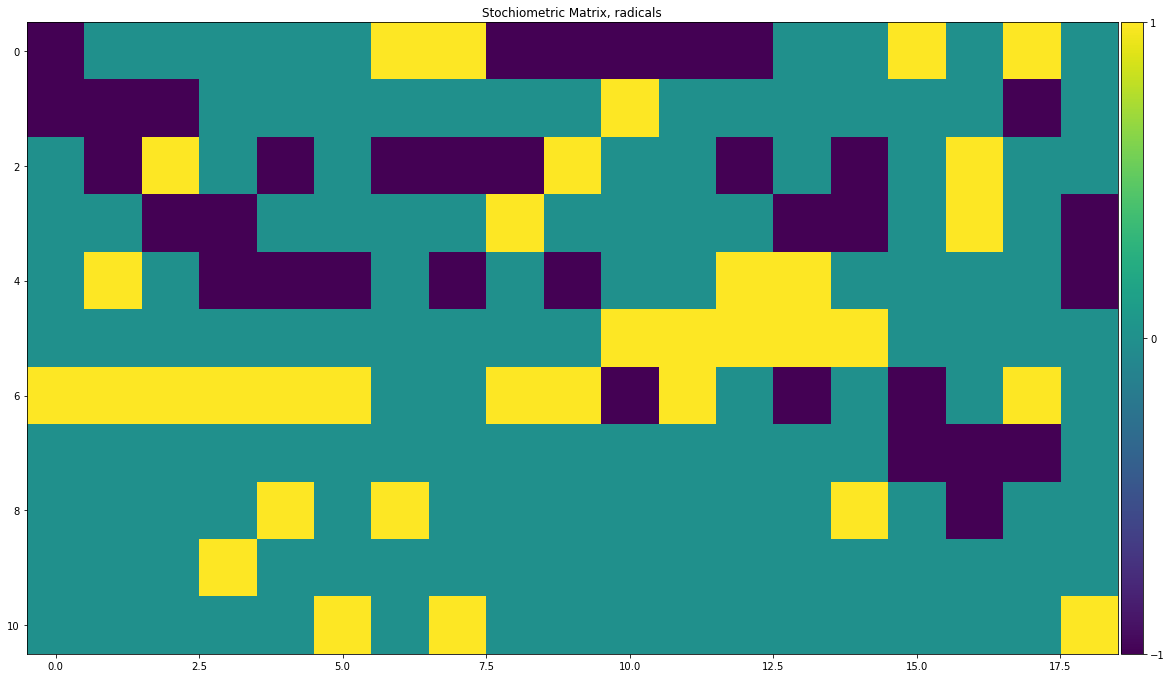

In [16]:
import matplotlib.pyplot as plt                          # Import Matplotllib.pyploy
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Import make_axes_locatabale

fig = plt.figure()                                       # Initalize a  Figure
fig.set_size_inches(20, 20)                              # Set Size
 
ax = plt.gca()                                           # Get the current Axes instance on the current figure, or create one.
ax.set_title("Stochiometric Matrix, radicals") 
im = ax.imshow(S_np)                #  Store plot of Matrix 
divider = make_axes_locatable(ax)                        # Locate axes 
cax = divider.append_axes("right", size="2%", pad=0.05)  # format color bar

#plt.colorbar(im, cax=cax)
plt.colorbar(im,ticks=[-1.0, 0.0, 1.0],cax=cax)          # Plot matrix with color bar
plt.show()          

SVD ANALYSIS

In [17]:
U,Sd,VT = np.linalg.svd(S_np,full_matrices=False)# economy svd (first m columns of u)
Sd = np.diag(Sd)
print("Shapes:  U:",U.shape," S:",Sd.shape," VT:",VT.shape)

Shapes:  U: (11, 11)  S: (11, 11)  VT: (11, 19)


In [18]:
S_np.shape

(11, 19)

In [37]:
np.linalg.matrix_rank(Sd)

11

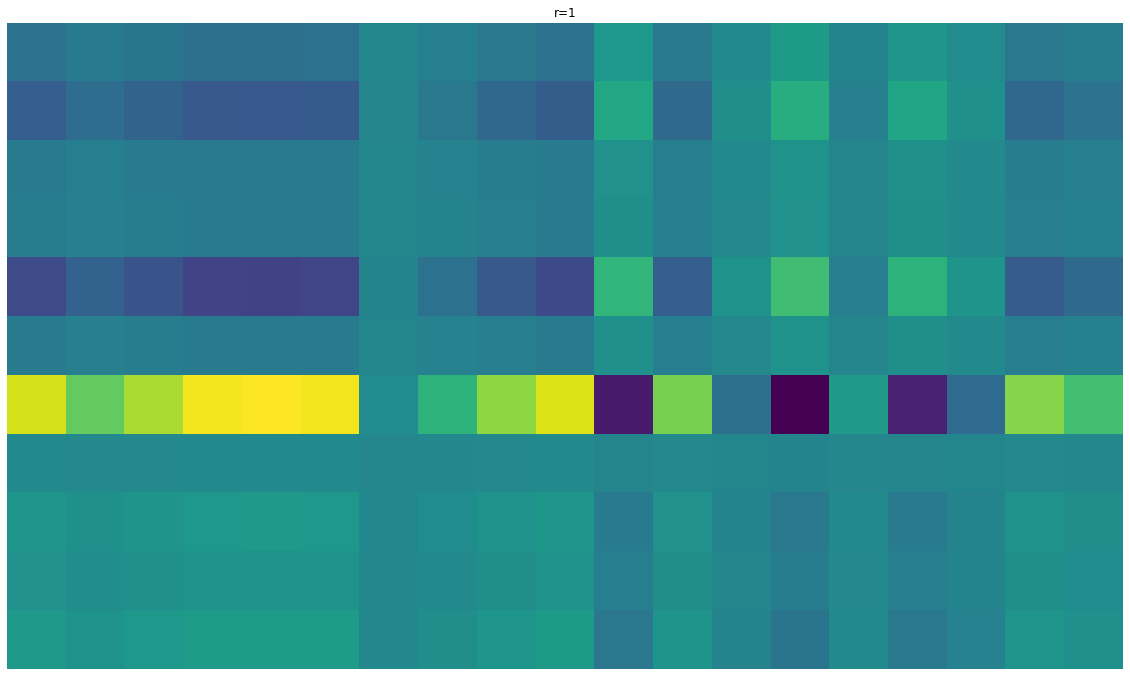

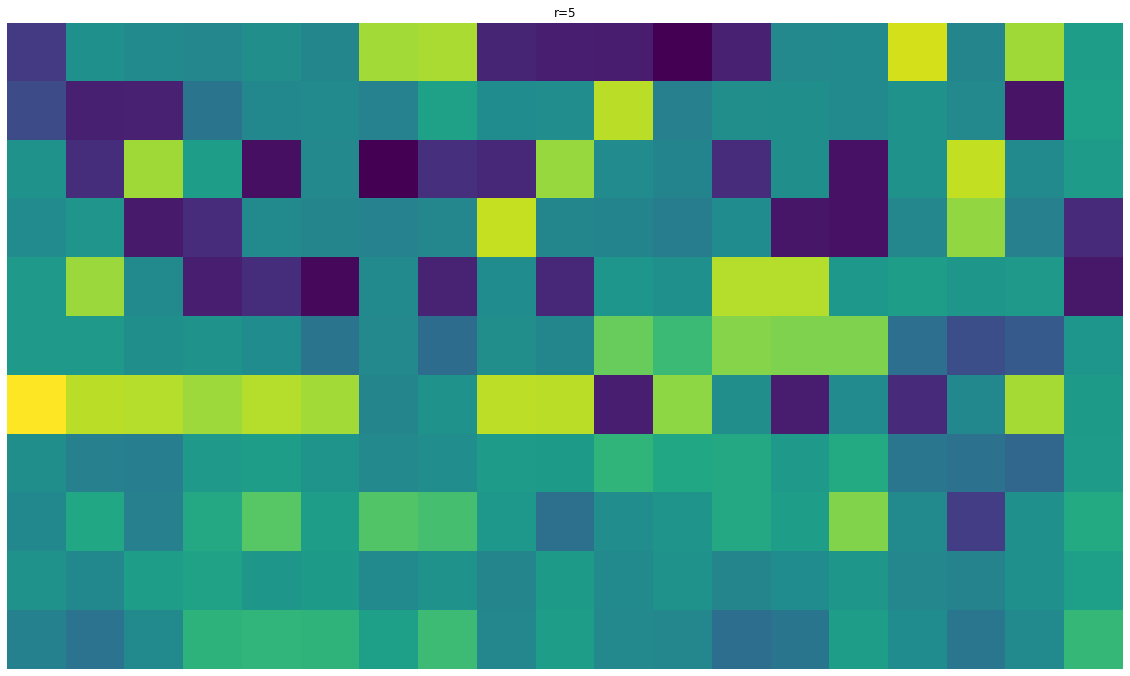

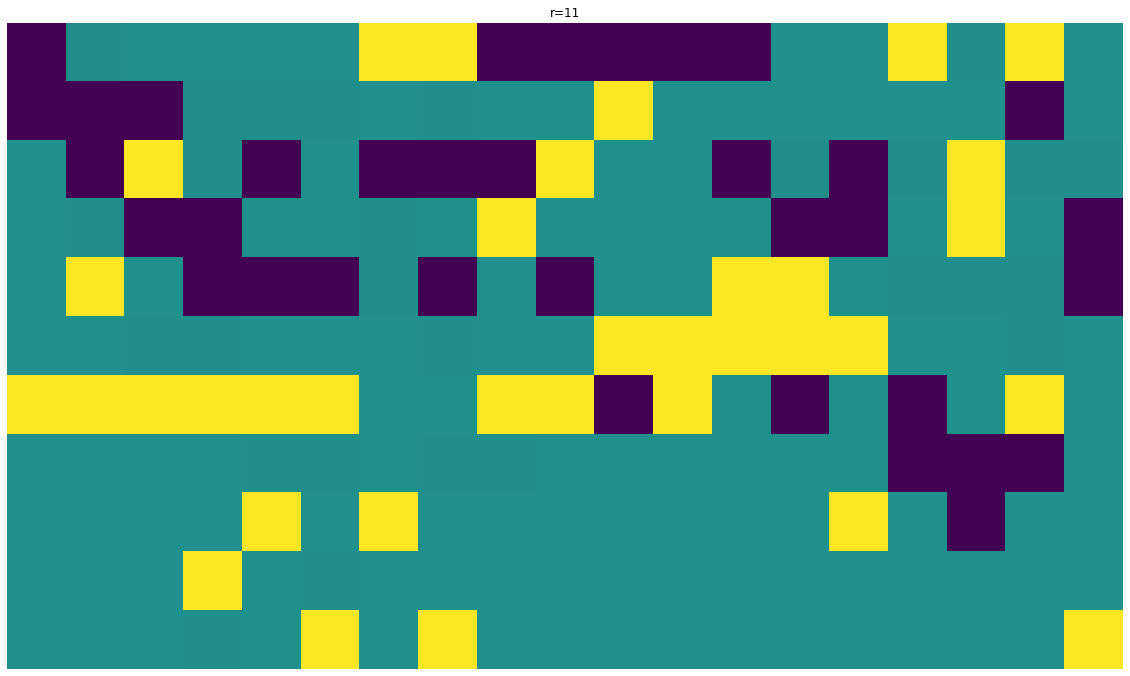

In [38]:
# RANK r APROXIMATIONS of S
j = 0
for r in (1,5,11):
    Sapprox = U[:,:r]@Sd[0:r,:r]@VT[:r,:]
    fig = plt.figure(j+1)
    fig.set_size_inches(20, 20)                             
    img = plt.imshow(Sapprox)
    plt.title('r=' + str(r))
    plt.axis('off')
    plt.show()

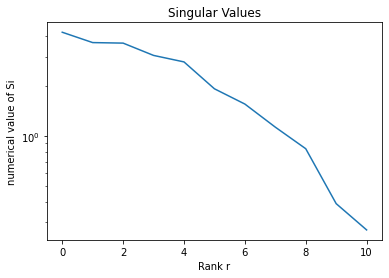

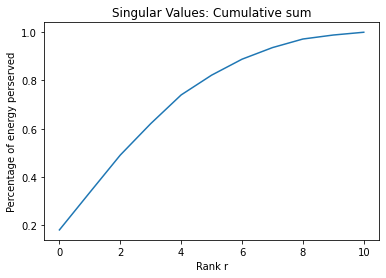

In [39]:
plt.figure(1)
plt.semilogy(np.diag(Sd))
plt.title('Singular Values')
plt.xlabel('Rank r')
plt.ylabel('numerical value of Si')
plt.show()


# Fraction of enery capture
plt.figure(2)
plt.plot(np.cumsum(np.diag(Sd))/np.sum(np.diag(Sd)))
plt.title('Singular Values: Cumulative sum')
plt.xlabel('Rank r')
plt.ylabel('Percentage of energy perserved')
plt.show()

NUMERICAL ROUND of Stochiometric matrix S ratining 99.99% of info

In [40]:
S_r200 = np.round(Sapprox,1) # get numerical values between 1 and -1
S_r200

array([[-1., -0.,  0.,  0.,  0.,  0.,  1.,  1., -1., -1., -1., -1., -1.,
        -0.,  0.,  1., -0.,  1.,  0.],
       [-1., -1., -1., -0., -0., -0., -0., -0., -0., -0.,  1., -0.,  0.,
         0., -0.,  0.,  0., -1., -0.],
       [ 0., -1.,  1., -0., -1., -0., -1., -1., -1.,  1.,  0.,  0., -1.,
        -0., -1., -0.,  1., -0., -0.],
       [ 0., -0., -1., -1., -0.,  0., -0., -0.,  1.,  0.,  0.,  0.,  0.,
        -1., -1.,  0.,  1., -0., -1.],
       [ 0.,  1., -0., -1., -1., -1., -0., -1., -0., -1.,  0., -0.,  1.,
         1.,  0., -0., -0., -0., -1.],
       [ 0.,  0., -0., -0.,  0., -0., -0., -0.,  0.,  0.,  1.,  1.,  1.,
         1.,  1., -0.,  0., -0., -0.],
       [ 1.,  1.,  1.,  1.,  1.,  1., -0., -0.,  1.,  1., -1.,  1., -0.,
        -1.,  0., -1.,  0.,  1., -0.],
       [ 0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0.,  0.,  0.,  0.,
         0., -0., -1., -1., -1., -0.],
       [-0.,  0., -0., -0.,  1., -0.,  1.,  0., -0., -0., -0.,  0.,  0.,
         0.,  1.,  0., -1.,  0.

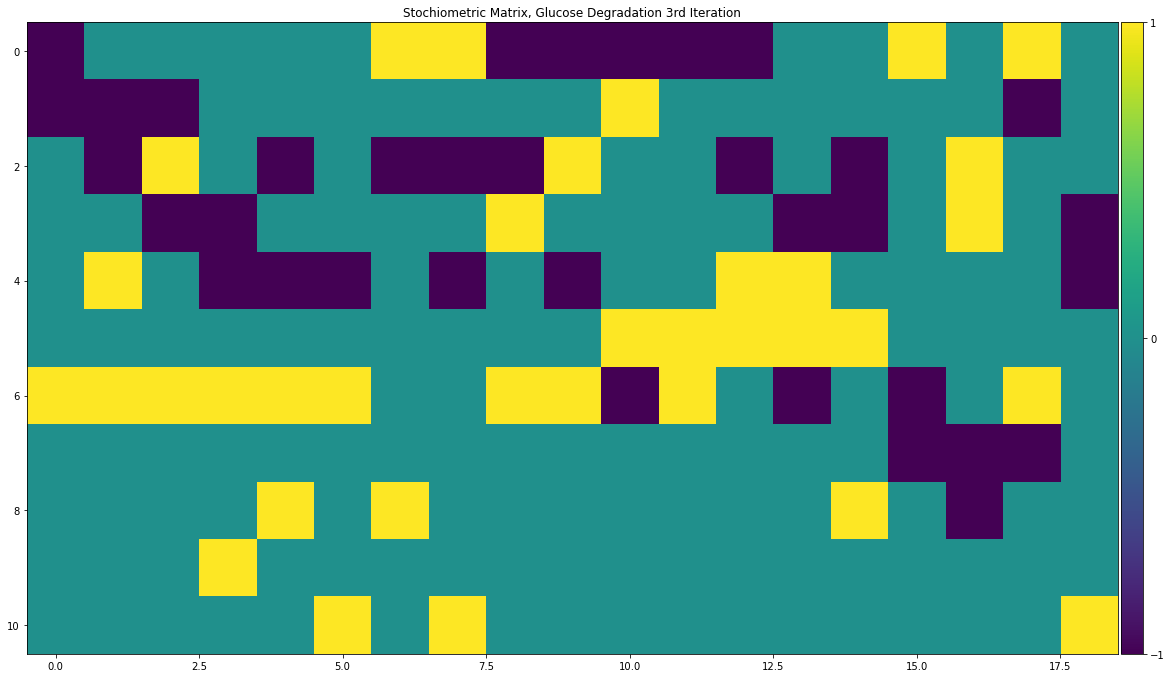

In [42]:
fig = plt.figure()                                       # Initalize a  Figure
fig.set_size_inches(20, 20)                              # Set Size
 
ax = plt.gca()                                           # Get the current Axes instance on the current figure, or create one.
ax.set_title("Stochiometric Matrix, Glucose Degradation 3rd Iteration") 
im = ax.imshow(S_r200                   )                #  Store plot of Matrix 
divider = make_axes_locatable(ax)                        # Locate axes 
cax = divider.append_axes("right", size="2%", pad=0.05)  # format color bar

#plt.colorbar(im, cax=cax)
plt.colorbar(im,ticks=[-1.0, 0.0, 1.0],cax=cax)          # Plot matrix with color bar
plt.show()          

In [43]:
import scipy.io
scipy.io.savemat('test.mat', dict(S=S_r200))
print(S_r200.shape)

(11, 19)


In [44]:
import scipy.linalg as  lin
N_S = lin.null_space(S_r200)
N_ST = lin.null_space(S_r200.T)

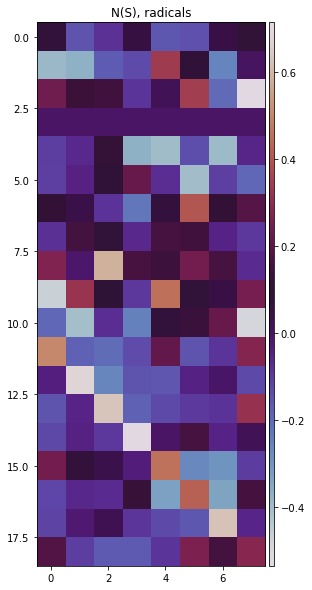

In [48]:
fig = plt.figure()                                       # Initalize a  Figure
fig.set_size_inches(10, 10)                              # Set Size
 
ax = plt.gca()                                           # Get the current Axes instance on the current figure, or create one.
ax.set_title("N(S), radicals") 
im = ax.imshow(N_S ,cmap=plt.cm.twilight)                #  Store plot of Matrix 
divider = make_axes_locatable(ax)                        # Locate axes 
cax = divider.append_axes("right", size="2%", pad=0.05)  # format color bar

#plt.colorbar(im, cax=cax)
plt.colorbar(im,cax=cax)          # Plot matrix with color bar
plt.show()    

C:\Users\Eduardo\miniconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  


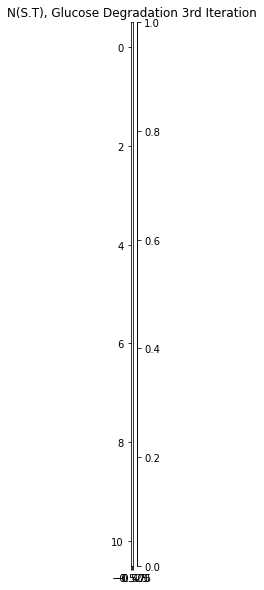

In [46]:
fig = plt.figure()                                       # Initalize a  Figure
fig.set_size_inches(10, 10)                              # Set Size
 
ax = plt.gca()                                           # Get the current Axes instance on the current figure, or create one.
ax.set_title("N(S.T), Glucose Degradation 3rd Iteration") 
im = ax.imshow(N_ST ,cmap=plt.cm.twilight)                #  Store plot of Matrix 
divider = make_axes_locatable(ax)                        # Locate axes 
cax = divider.append_axes("right", size="2%", pad=0.05)  # format color bar

#plt.colorbar(im, cax=cax)
plt.colorbar(im,cax=cax)          # Plot matrix with color bar
plt.show()    

In [50]:
N_S

array([[ 7.68312325e-02, -1.51303260e-01, -8.00328708e-02,
         6.06397494e-02, -1.59323512e-01, -1.43132029e-01,
         4.91031382e-02,  9.55518173e-02],
       [-3.88392487e-01, -3.69762418e-01, -1.67586094e-01,
        -1.32491921e-01,  3.40665100e-01,  8.47645345e-02,
        -2.56134988e-01,  6.22636582e-03],
       [ 2.38096016e-01,  1.31555153e-01,  1.46710935e-01,
        -8.78160238e-02,  2.16517986e-02,  3.47563839e-01,
        -1.97328085e-01, -5.34736661e-01],
       [-1.69523768e-18, -2.96182931e-17, -1.10474930e-17,
        -7.21502749e-17, -5.64358115e-17, -5.20417043e-18,
        -1.73472348e-17,  8.46761897e-17],
       [-1.05939986e-01, -6.10882823e-02,  1.09690673e-01,
        -3.68851228e-01, -4.01409221e-01, -1.38497979e-01,
        -3.93628873e-01, -5.31390311e-02],
       [-1.06255313e-01, -4.70229977e-02,  8.26267877e-02,
         2.24290588e-01, -7.24339993e-02, -4.02979900e-01,
        -1.06380537e-01, -1.89677362e-01],
       [ 1.06255313e-01,  4.702299

In [52]:
N_ST

array([], shape=(11, 0), dtype=float64)